# Slice & Aggregate cleaned AWS CloudWatch data

https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/metrics-collected-by-CloudWatch-agent.html

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("cleaned_merged.csv").set_index('Unnamed: 0')
df.index.name = None
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu28 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu28 host:ip

In [46]:
def collate(df, host_str, metric_str, aggreg_func='mean'):
    """ Take a time-sliced df, filter by host name and aggregate"""
    df_agg = (
        df.loc[: , df.columns.str.contains(host_str) & df.columns.str.contains(metric_str)]
        #.dropna()
        .dropna(how='all')
        .aggregate(aggreg_func, axis='columns')
        .to_frame(name= aggreg_func + '_' + metric_str)
    )
    return df_agg 


def get_agg(df, host_str):
    return pd.concat([
        collate(df, host_str, 'cpu_usage_user', 'sum'),
        collate(df, host_str, 'cpu_usage_system', 'sum'),
        collate(df, host_str, 'cpu_usage_iowait', 'sum'),
        collate(df, host_str, 'mem_used_percent'),
        collate(df, host_str, 'diskio_reads', 'sum'),
        collate(df, host_str, 'diskio_writes', 'sum'),
    ], axis='columns')

def summarize(df, framework):
    df_summary = pd.DataFrame(
        {
            '%_cpu_usage': df['sum_cpu_usage_user'] + df['sum_cpu_usage_system'],
            '%_mem_used': df['mean_mem_used_percent'],
            'count_diskio_ops': df['sum_diskio_reads'] + df['sum_diskio_writes'],
        }
    )
    start = df_summary.index[0]
    df_summary.index = df_summary.index - start
    df_summary.index = df_summary.index.total_seconds() / 60
    df_summary.index = df_summary.index.astype(int)
    
    df_summary['framework'] = framework
    
    return df_summary

def plot_fig(df, y_label):
    plt.figure(figsize = (10,3), dpi=300)
    #plt.title('')
    plt.xlabel('running time (min)')
    g = sns.lineplot(data=df, y=y_label, x="index", hue='framework')
    g.legend_.set_title(None)

In [25]:
# cluster-size-1
df_data_cs1 = pd.concat([
    summarize(get_agg(df.loc['2022-05-10 15:43:00':'2022-05-10 15:46:00'], 'host:ip-172-31-25-37'), 'dask'),
    summarize(get_agg(df.loc['2022-05-10 15:52:00':'2022-05-10 16:14:00'], 'host:ip-172-31-25-37'), 'pandas'),
    summarize(get_agg(df.loc['2022-05-10 16:16:00':'2022-05-10 16:42:00'], 'host:ip-172-31-25-37'), 'hadoop'),
    summarize(get_agg(df.loc['2022-05-10 15:48:00':'2022-05-10 15:50:00'], 'host:ip-172-31-25-37'), 'spark'),
    summarize(get_agg(df.loc['2022-05-10 15:28:00':'2022-05-10 15:36:00'], 'host:ip-172-31-25-37'), 'postgres'),
], axis=0)
#.reset_index().set_index(['index', 'framework']).plot()

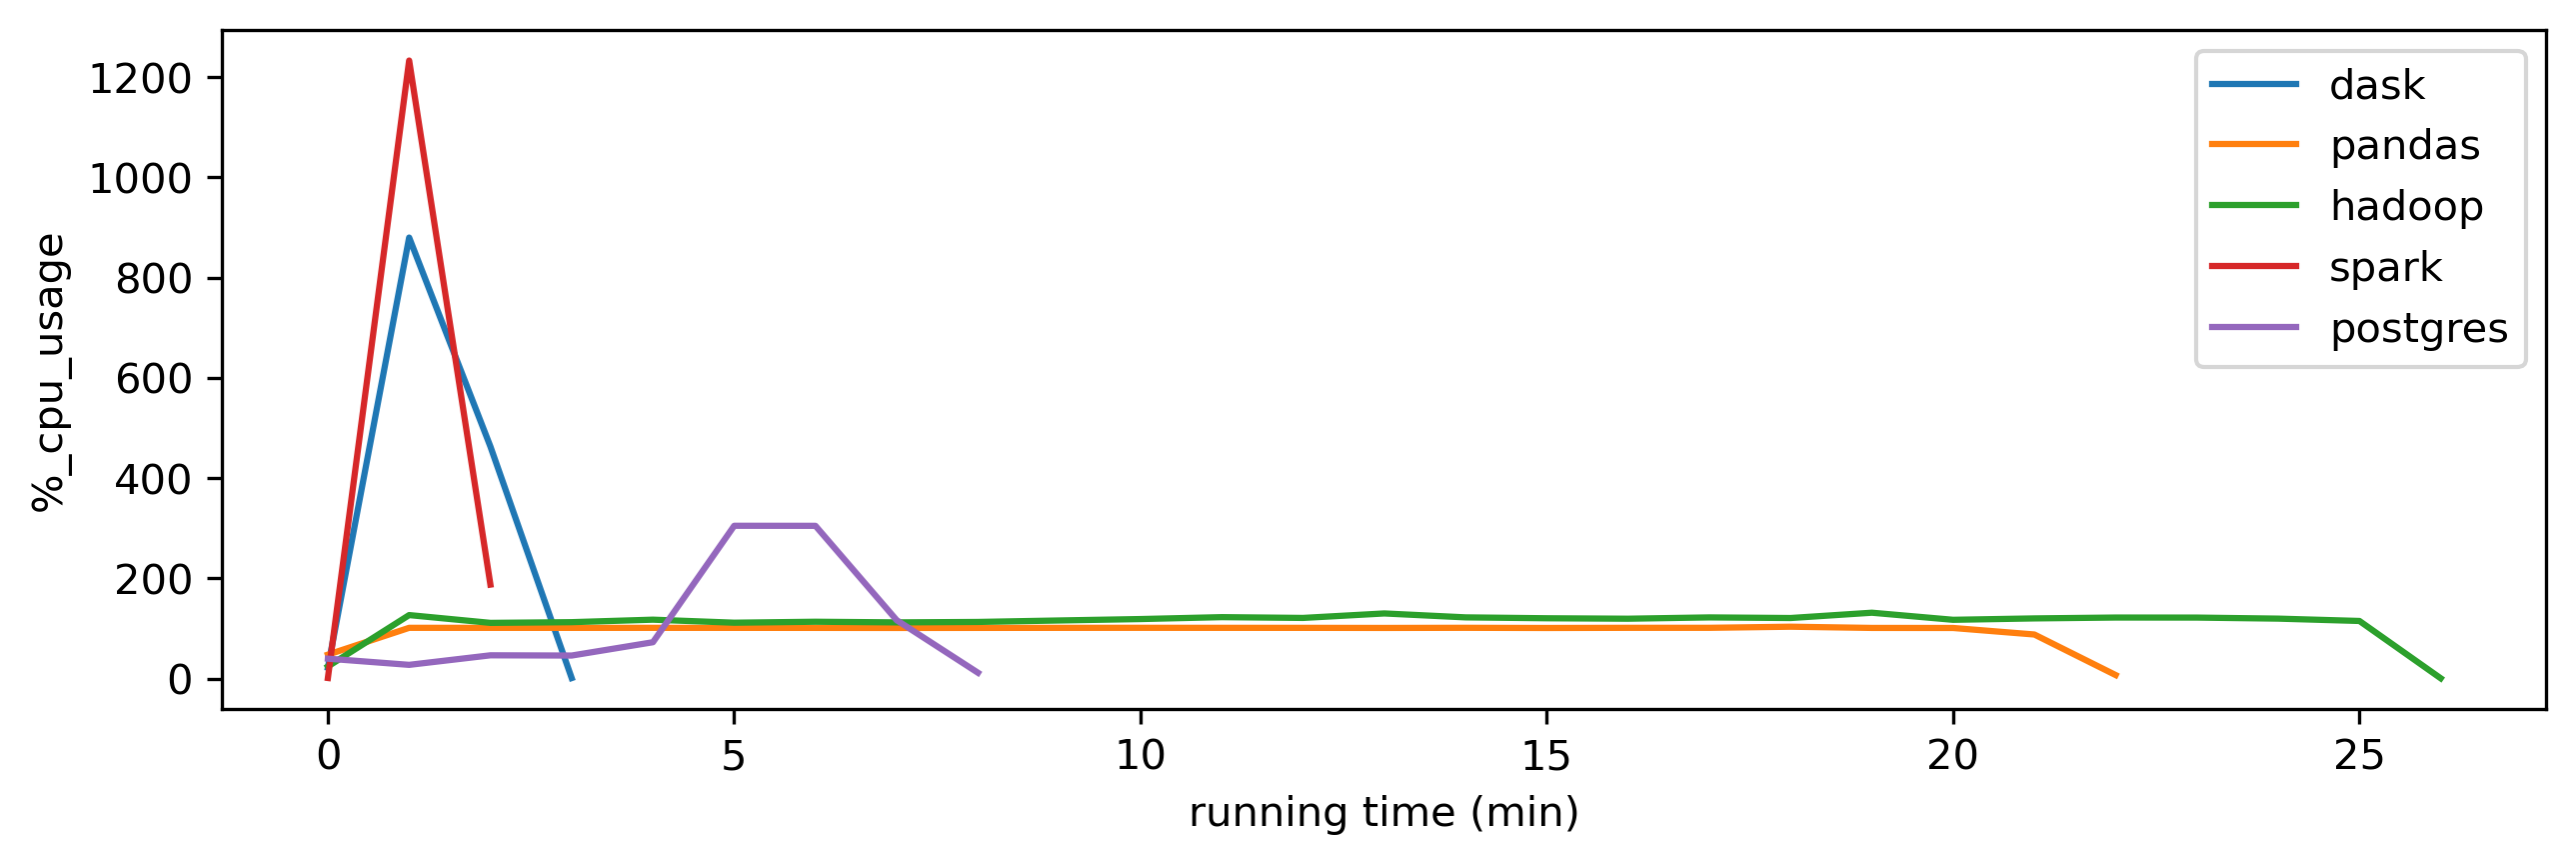

In [47]:
plot_fig(df_data_cs1.reset_index(), "%_cpu_usage")

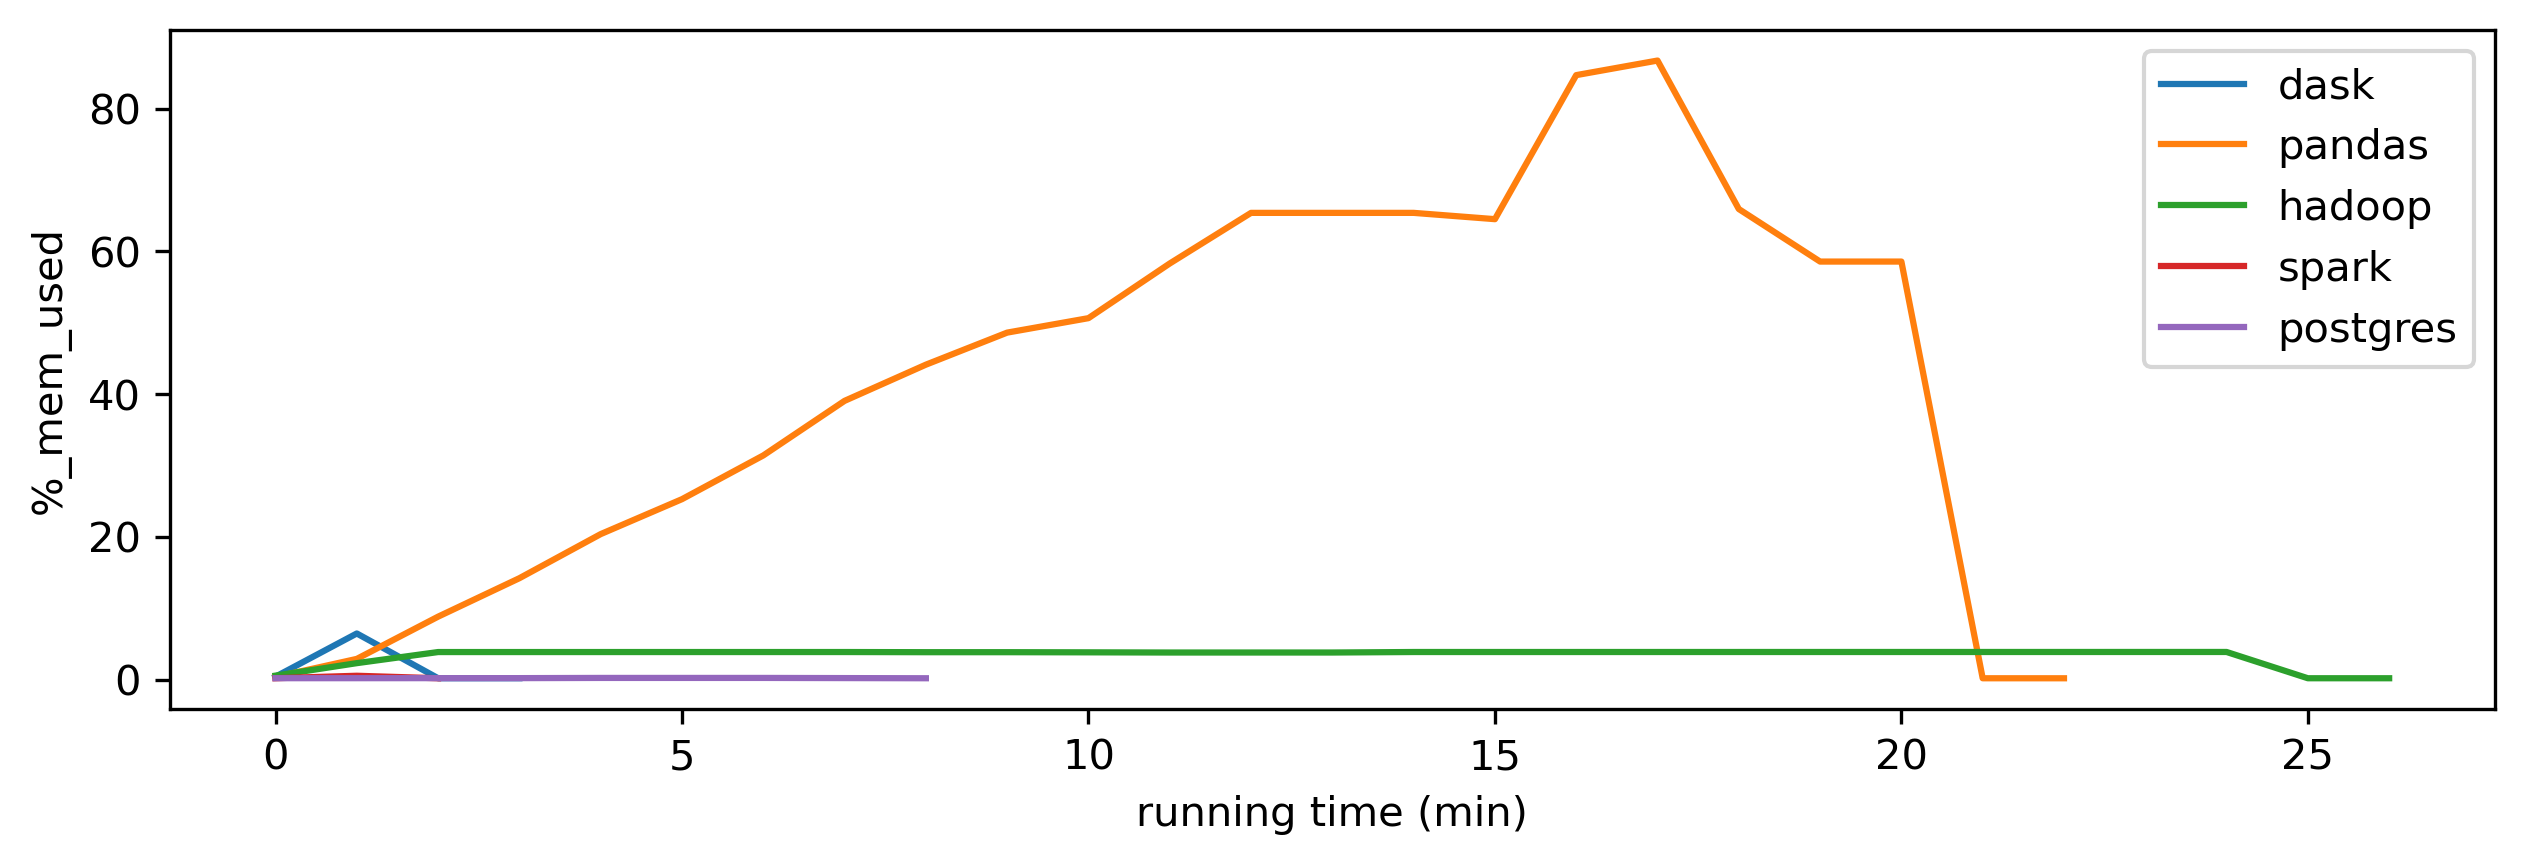

In [48]:
#sns.lineplot(data=df_data_cs1.reset_index(), y="%_mem_used", x="index", hue='framework')
plot_fig(df_data_cs1.reset_index(), "%_mem_used")

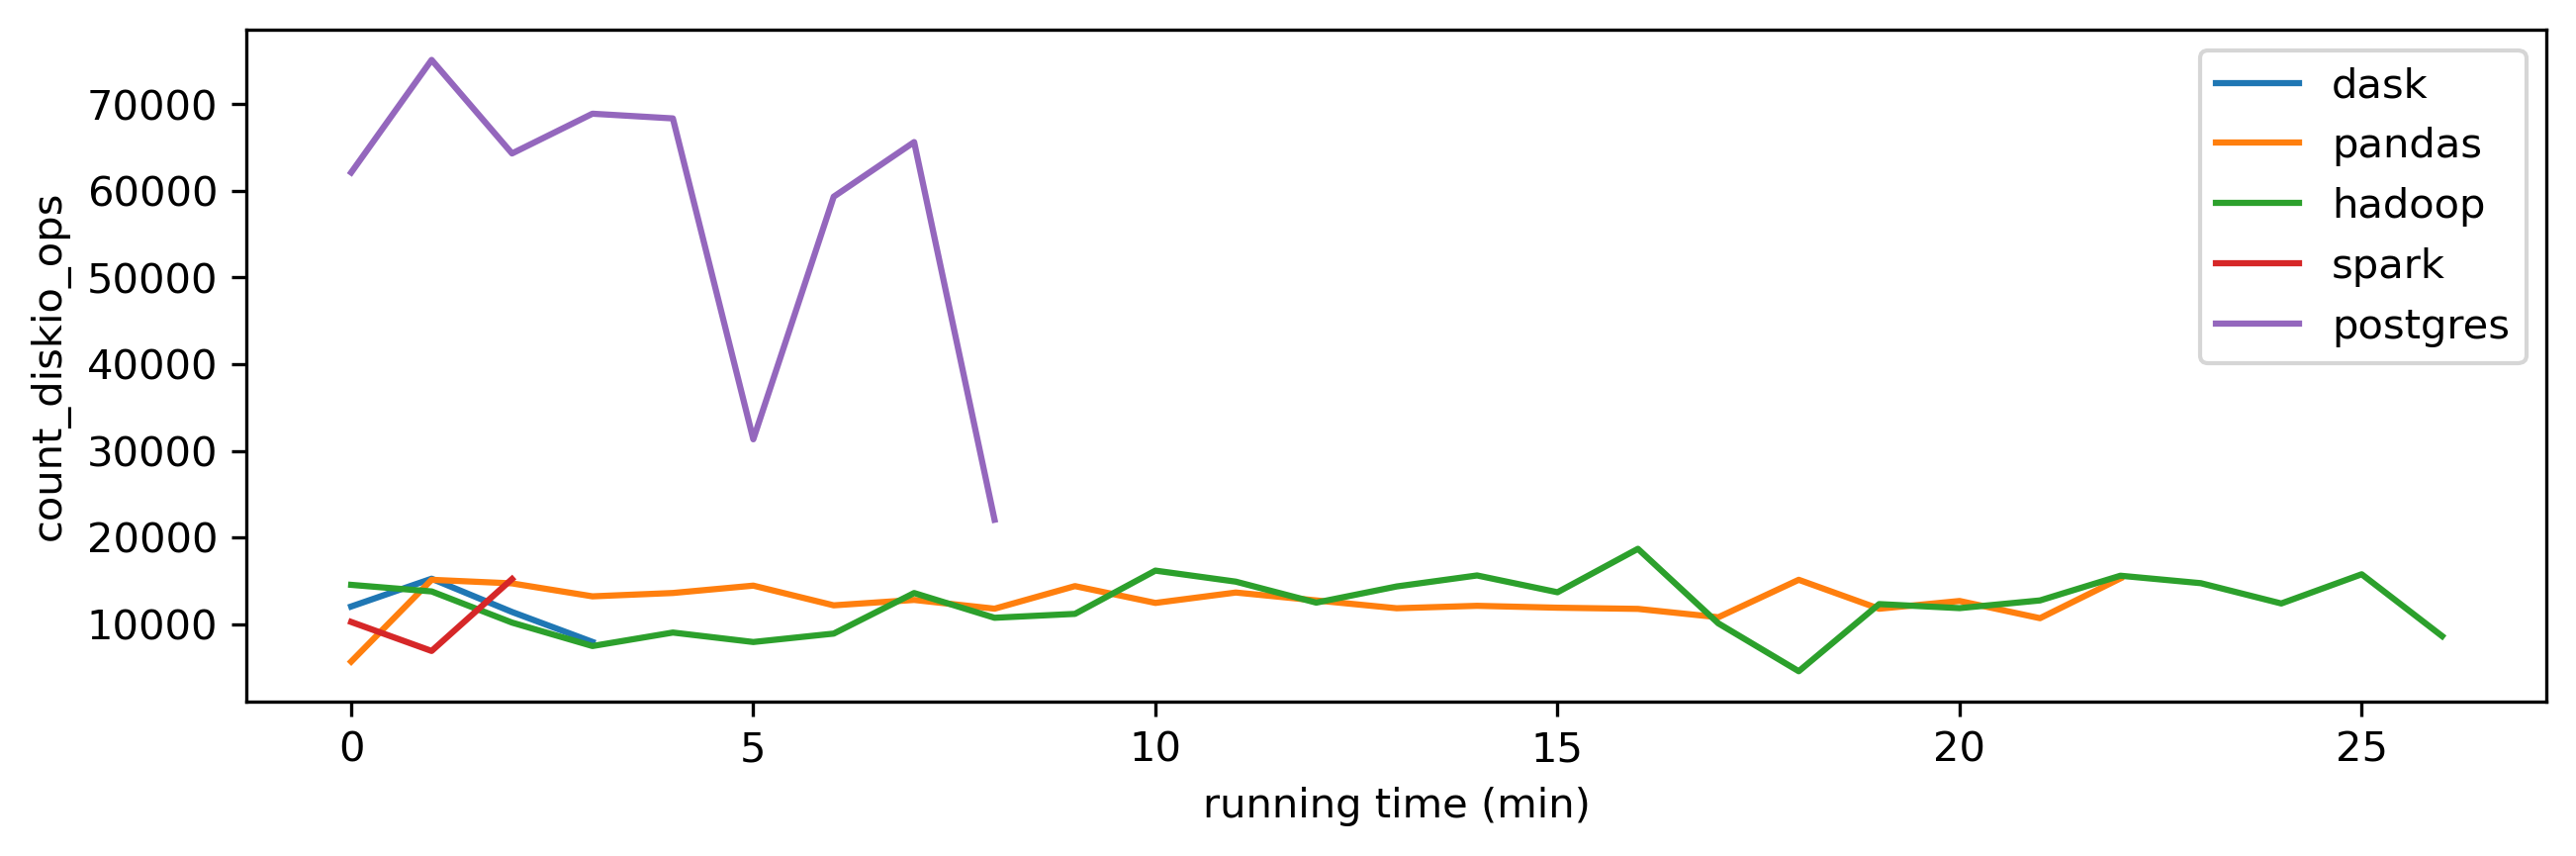

In [49]:
#sns.lineplot(data=df_data_cs1.reset_index(), y="count_diskio_ops", x="index", hue='framework')
plot_fig(df_data_cs1.reset_index(), "count_diskio_ops")

In [9]:
# cluster-size-3
df_data_cs3 = pd.concat([
    summarize(get_agg(df.loc['2022-05-09 14:40:00':'2022-05-09 14:47:00'], 'host:hadoop'), 'dask'),
    summarize(get_agg(df.loc['2022-05-09 15:14:00':'2022-05-09 15:18:00'], 'host:hadoop'), 'hadoop'),
    summarize(get_agg(df.loc['2022-05-09 15:28:00':'2022-05-09 15:30:00'], 'host:hadoop'), 'spark'),
], axis=0)

,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu0 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu1 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu10 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu11 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu12 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu13 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu14 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu15 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu16 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu17 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu18 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu19 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu2 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu20 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu21 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu22 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu23 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu24 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu25 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu26 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_idle,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_system,cpu:cpu27 host:ip-172-31-25-37 cpu_usage_iowait,cpu:cpu28 host:ip-172-31-25-37 cpu_usage_user,cpu:cpu28 host:ip

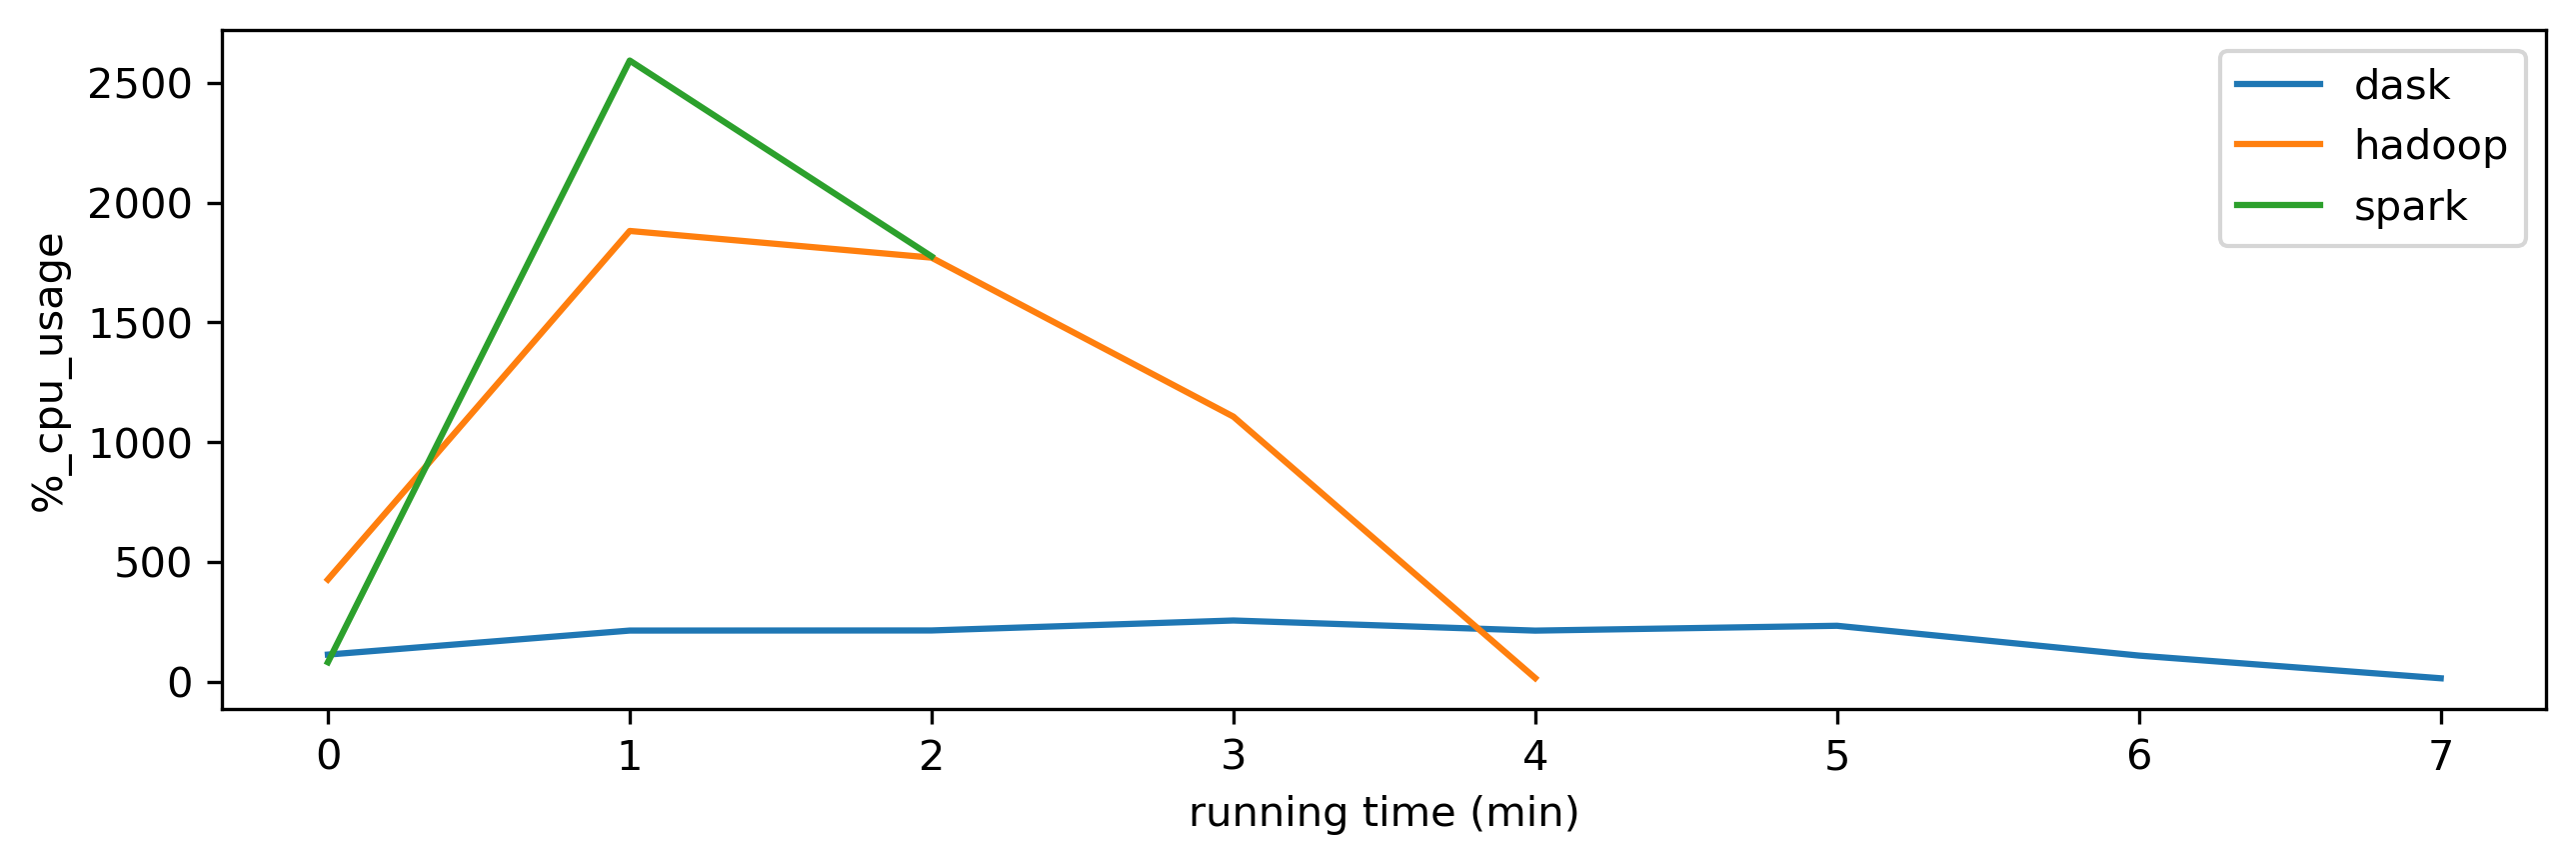

In [51]:
#sns.lineplot(data=df_data_cs3.reset_index(), y="%_cpu_usage", x="index", hue='framework')
plot_fig(df_data_cs3.reset_index(), "%_cpu_usage")

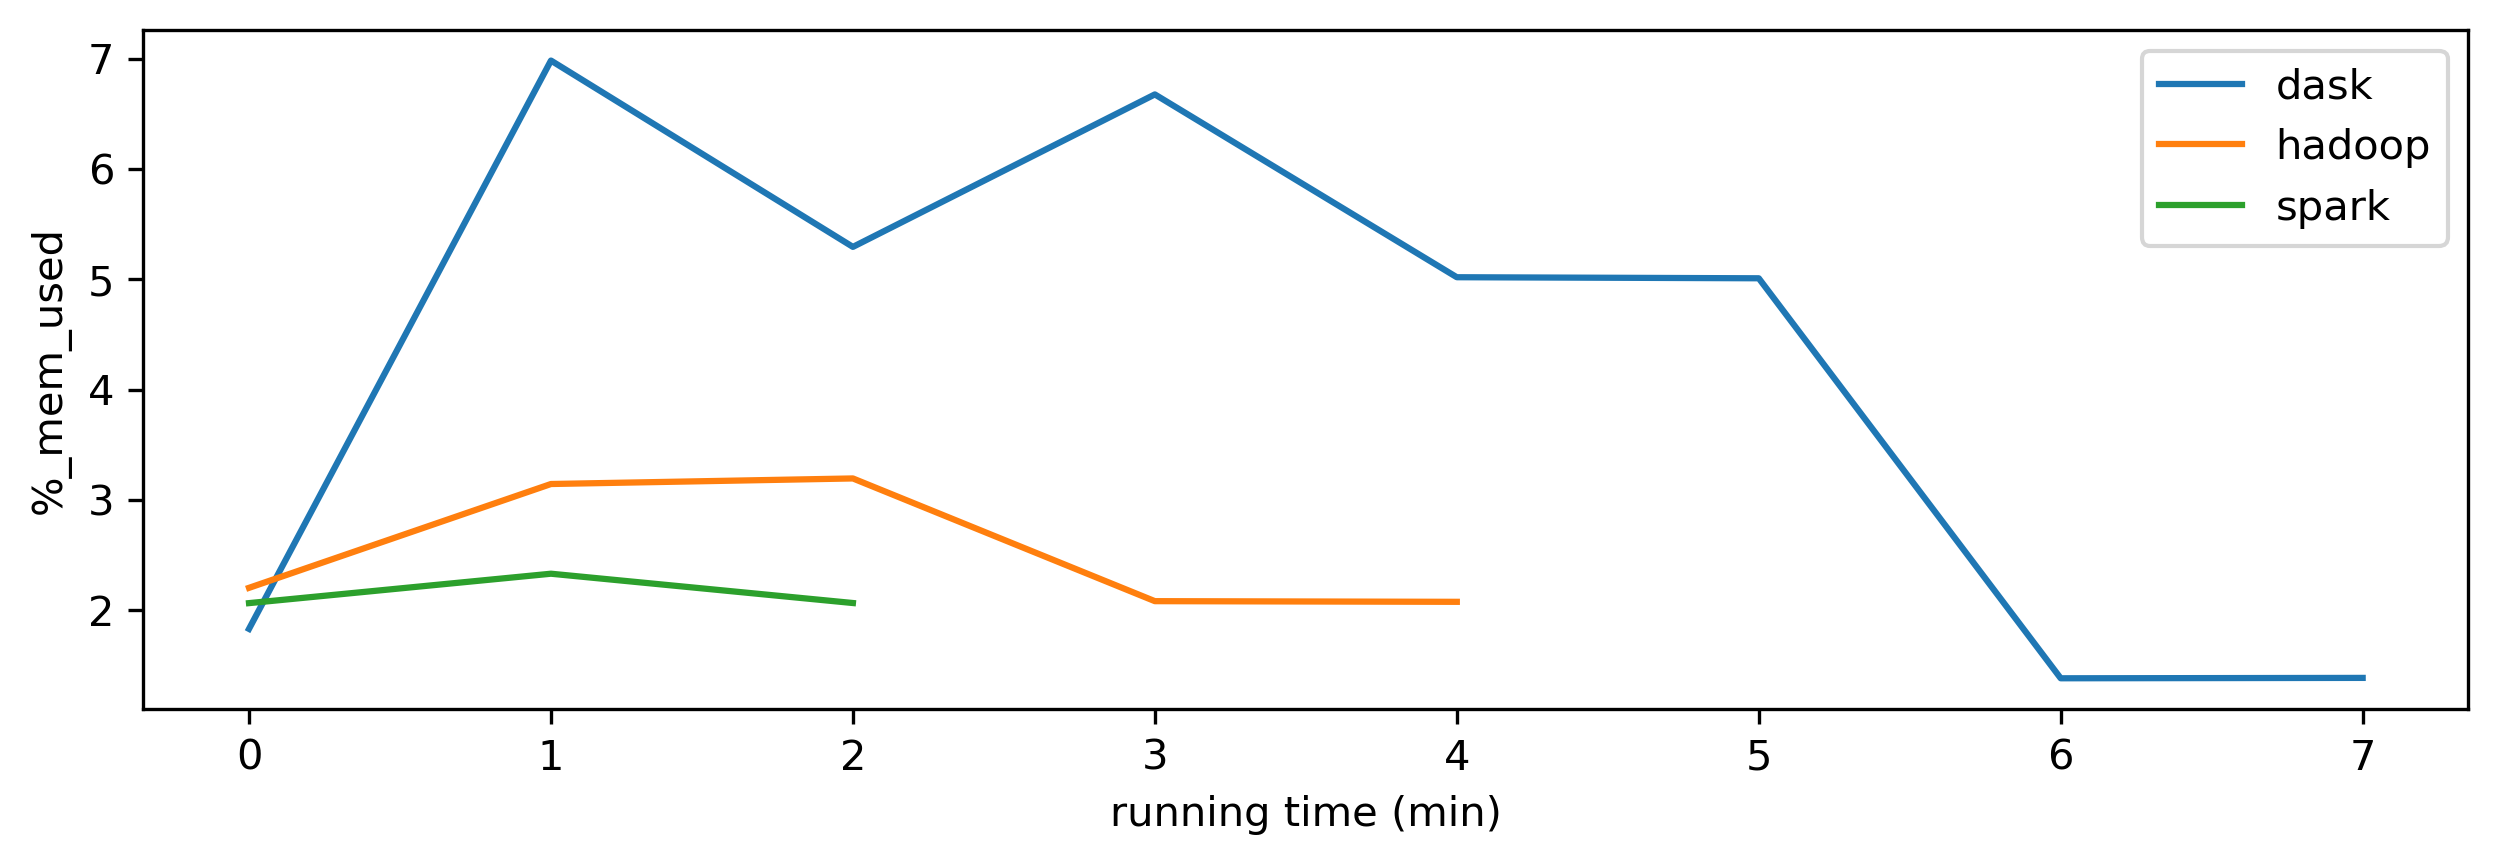

In [52]:
#sns.lineplot(data=df_data_cs3.reset_index(), y="%_mem_used", x="index", hue='framework')
plot_fig(df_data_cs3.reset_index(), "%_mem_used")

In [20]:
# cluster-size-6
df_data_cs6 = pd.concat([
    summarize(get_agg(df.loc['2022-05-10 11:05:00':'2022-05-10 11:08:00'], 'host:hadoop'), 'dask'),
    summarize(get_agg(df.loc['2022-05-10 09:42:00':'2022-05-10 09:43:00'], 'host:hadoop'), 'spark'),
    summarize(get_agg(df.loc['2022-05-10 08:14:00':'2022-05-10 08:17:00'], 'host:hadoop'), 'hadoop'),
], axis=0)

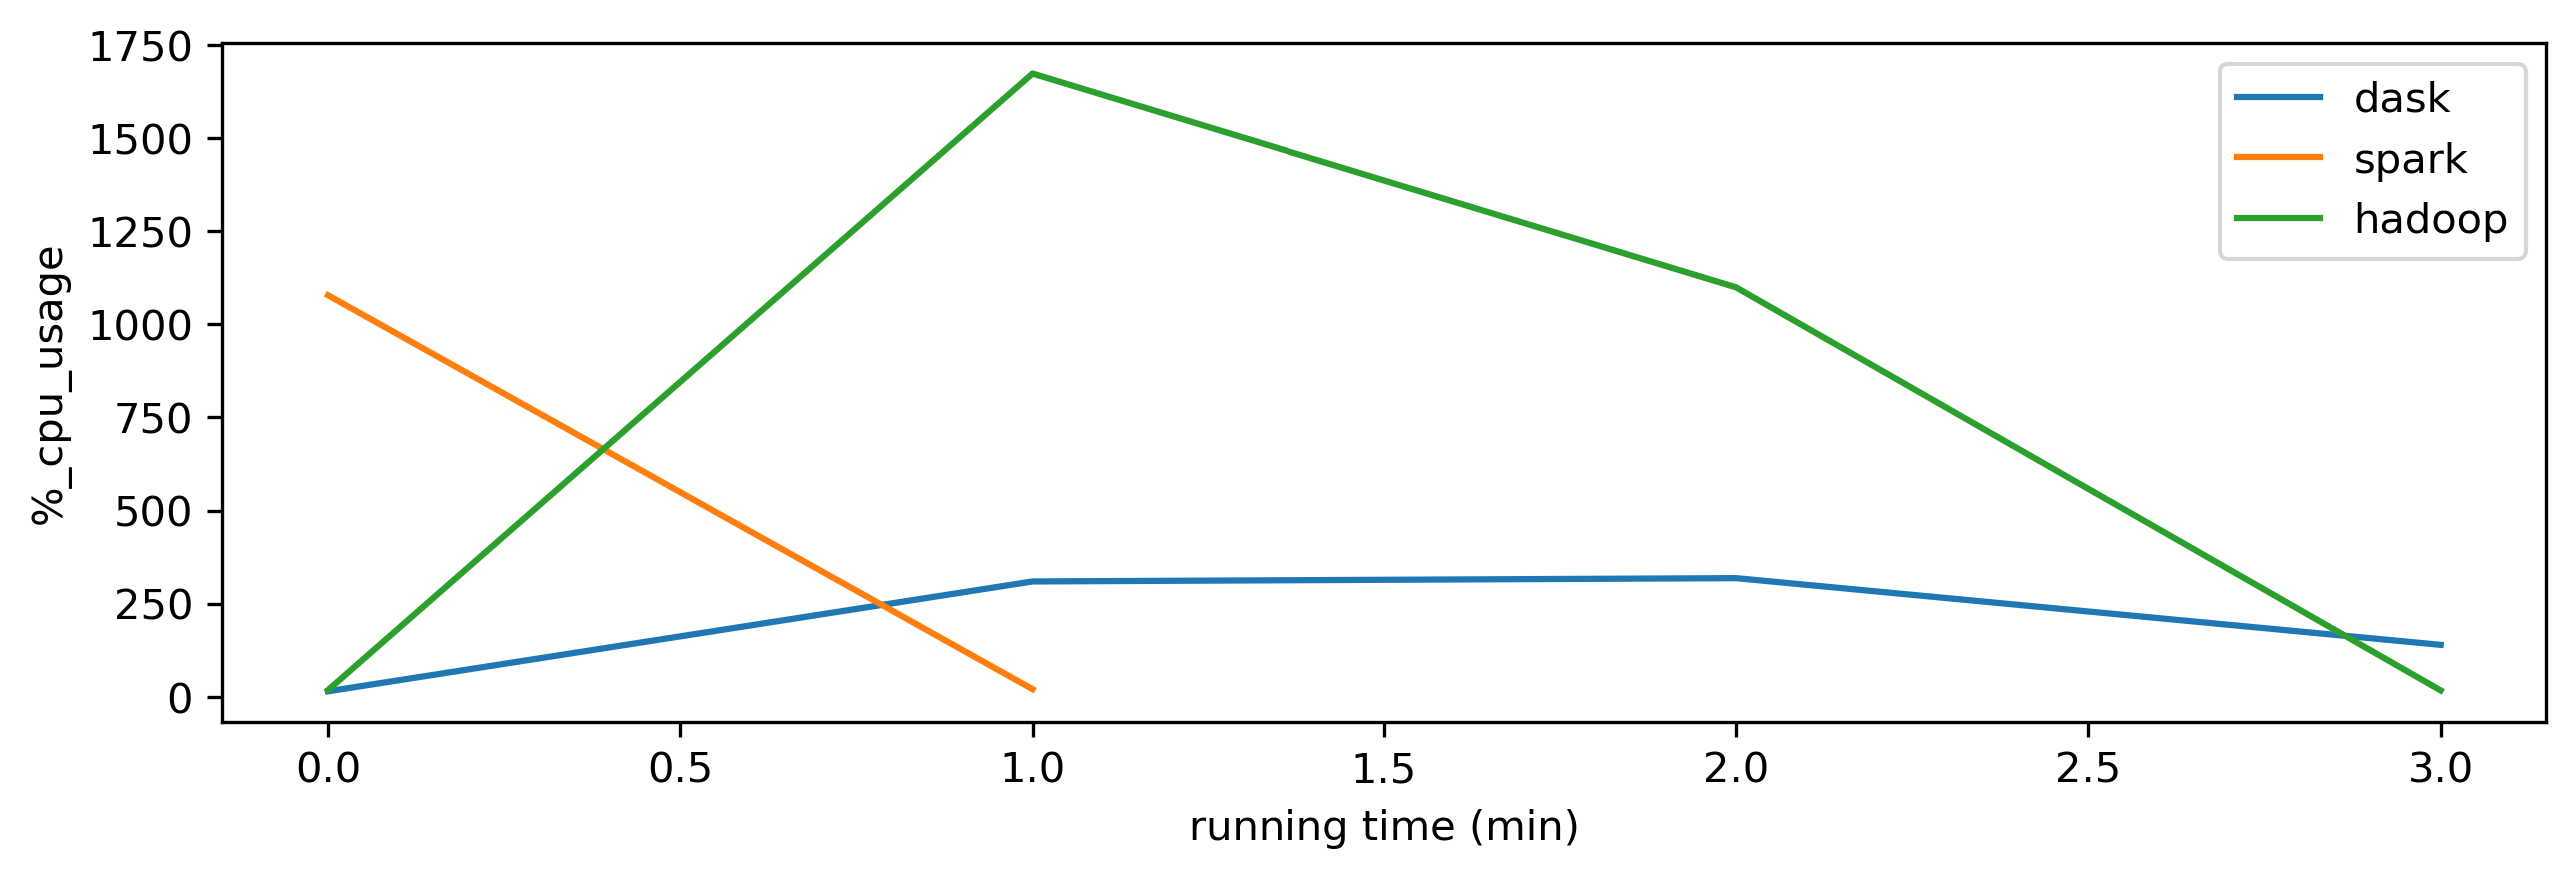

In [53]:
#sns.lineplot(data=df_data_cs6.reset_index(), y="%_cpu_usage", x="index", hue='framework')
plot_fig(df_data_cs6.reset_index(), "%_cpu_usage")

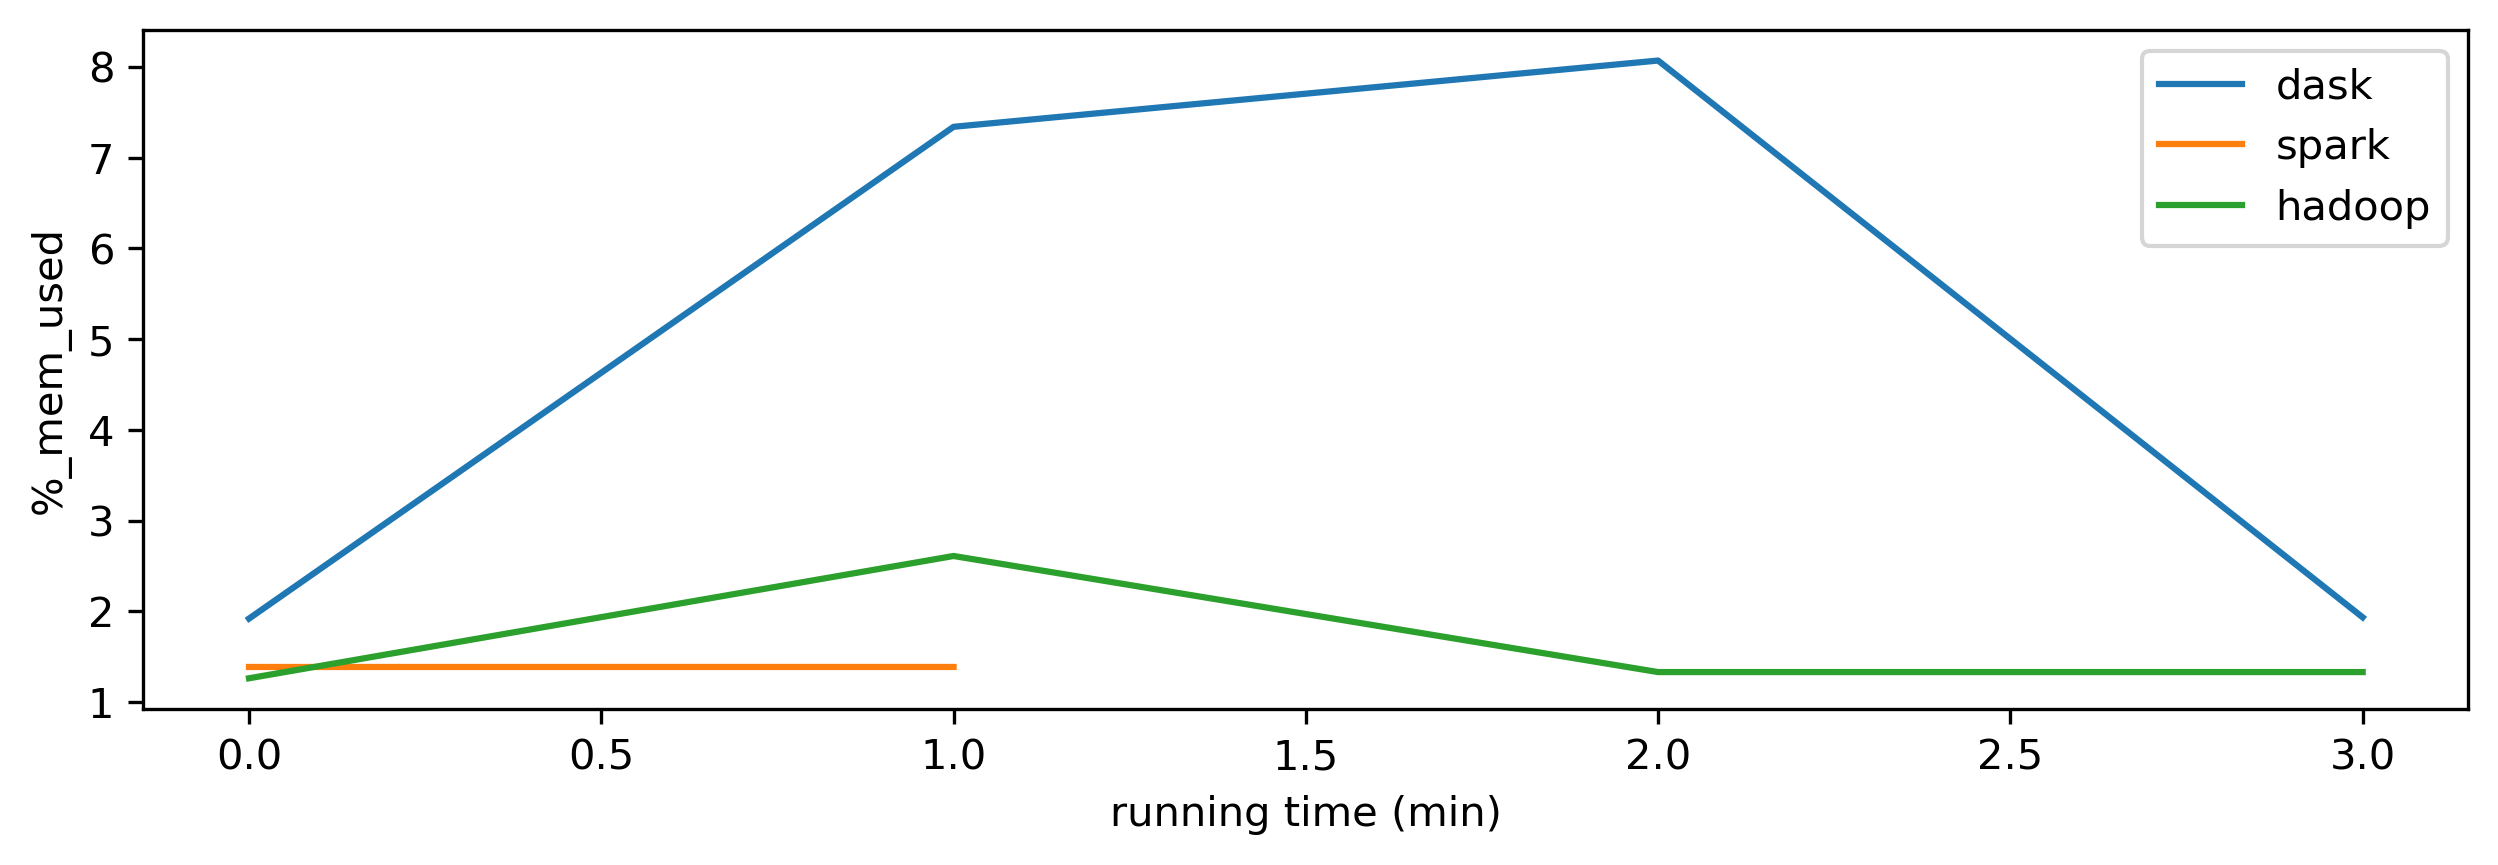

In [55]:
#sns.lineplot(data=df_data_cs6.reset_index(), y="%_mem_used", x="index", hue='framework')
plot_fig(df_data_cs6.reset_index(), "%_mem_used")

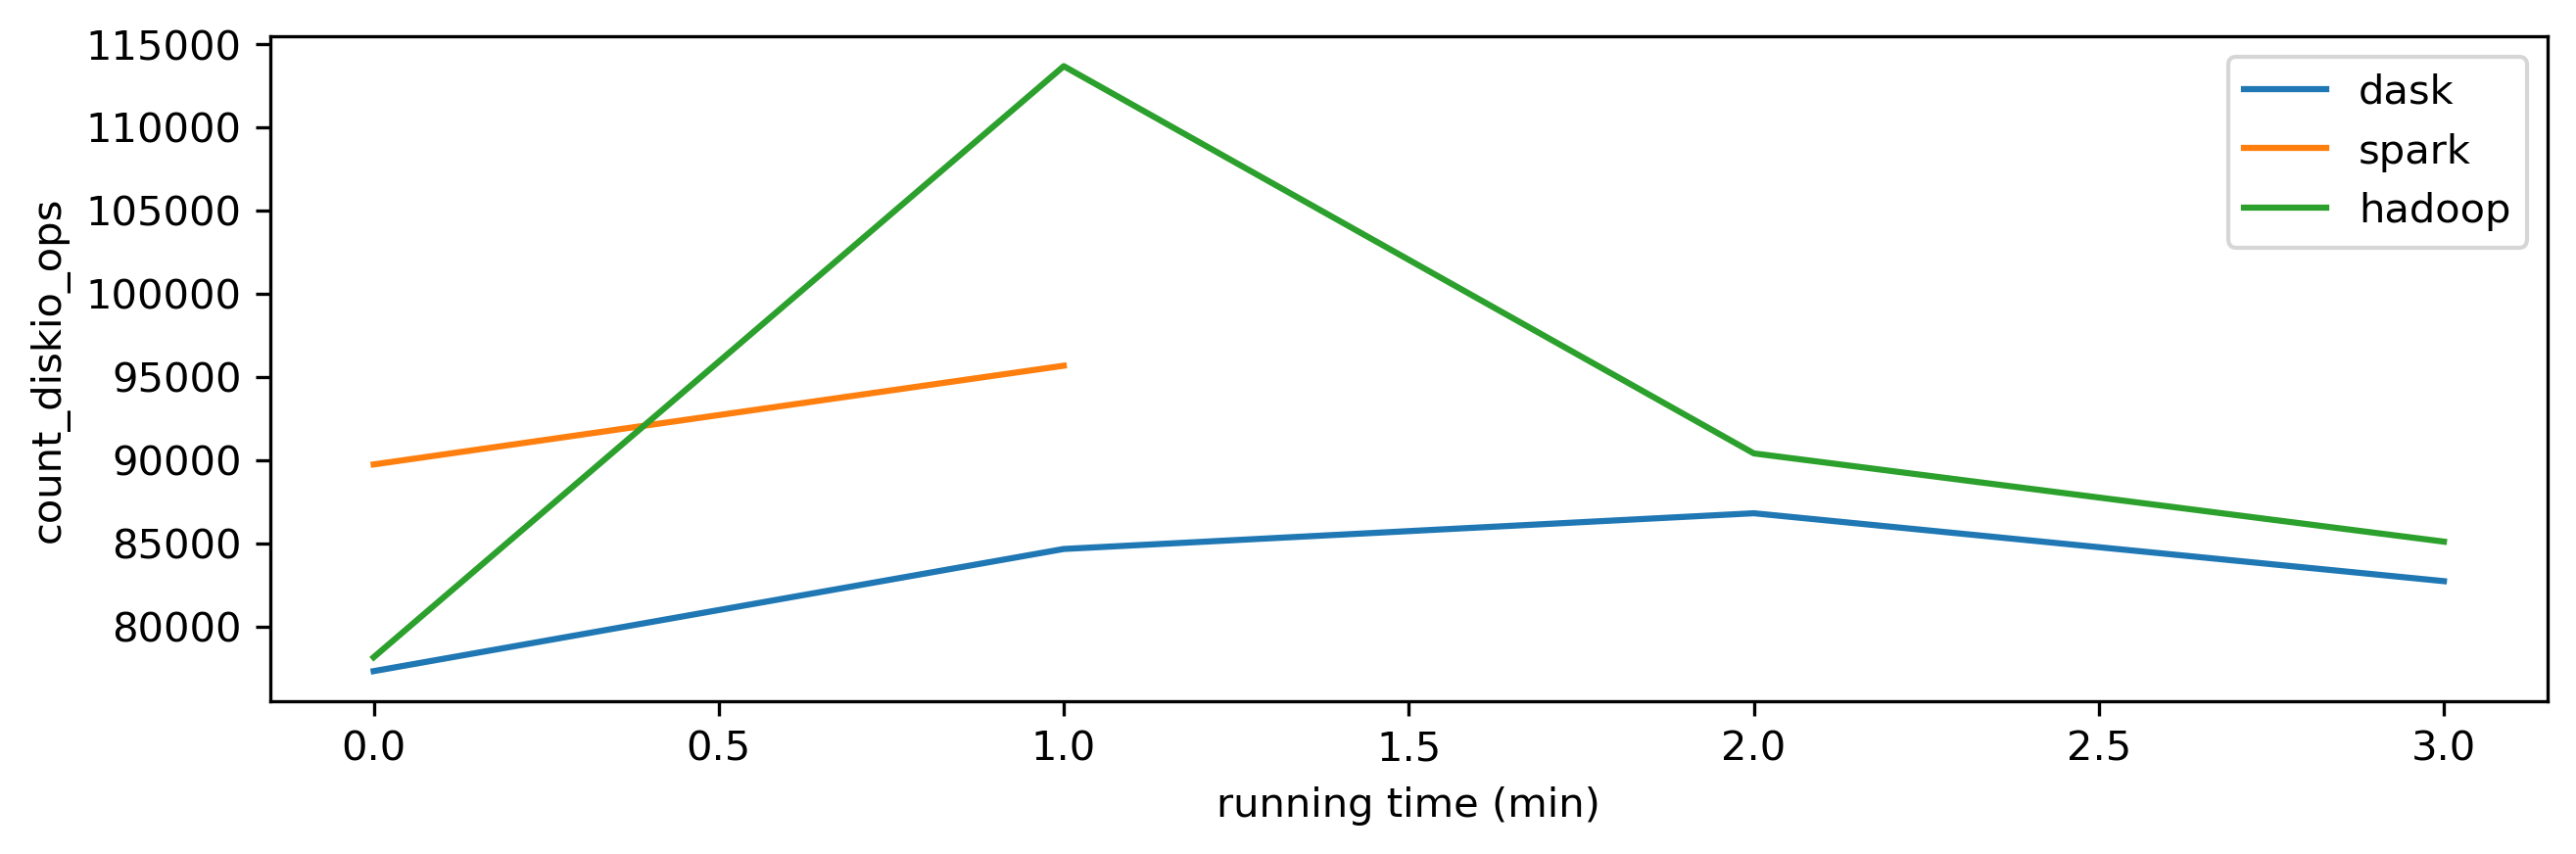

In [54]:
#sns.lineplot(data=df_data_cs6.reset_index(), y="%_mem_used", x="index", hue='framework')
plot_fig(df_data_cs6.reset_index(), "count_diskio_ops")